In [3]:
from mydataset import MyDataset
from torch.utils.data import DataLoader

import torchvision.transforms as tvt
import torch

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from time import time

from scipy.stats import wasserstein_distance


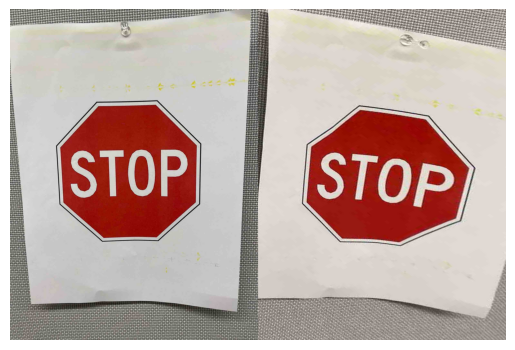

In [38]:
import torchvision.transforms as tvt
import torch

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from time import time

from scipy.stats import wasserstein_distance


img1 = Image.open("data/1.jpg")
img2 = Image.open("data/2.jpg")


def concatenate_img(img1, img2, name="concat.jpg"):
    concat_img = Image.new("RGB", (img1.size[0] * 2, img1.size[1]), "white")

    # pasting the first image (image_name, (position))
    concat_img.paste(img1, (0, 0))
    # pasting the second image (image_name, (position))
    concat_img.paste(img2, (img1.size[0], 0))

    # save the concatenated image
    plt.imshow(concat_img)
    plt.axis("off")
    plt.savefig(f"solutions/{name}")


concatenate_img(img1, img2)


# apply affine transform to img2
affine_tr = tvt.RandomAffine((30, 40))
img2 = affine_tr(img2)

# save the transformed image
img2.save("solutions/2_aff.jpg")
concatenate_img(img1, img2, name="concat_aff.jpg")


# apply perspective transform to img2
start_pts = [[851, 728], [973, 683], [851, 1171], [961, 1110]]
end_pts = [[546, 572], [917, 578], [579, 1431], [925, 1431]]

transformed_image = tvt.functional.perspective(
    img2, startpoints=start_pts, endpoints=end_pts
)
transformed_image.save("solutions/2_aff_persp.jpg")
concatenate_img(img1, transformed_image, name="concat_aff_pers.jpg")


Wasserstein distance between the two images is 0.001020476357306882


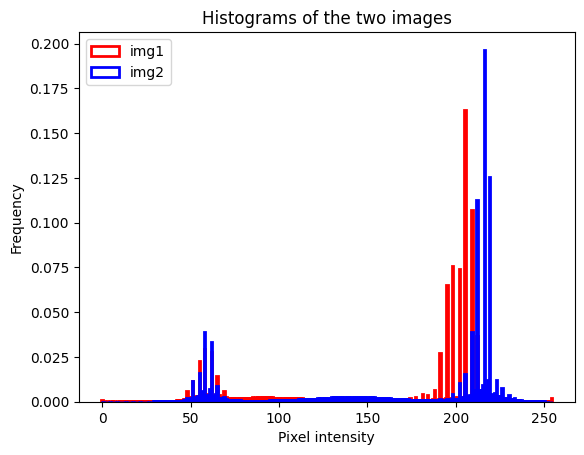

In [39]:
def get_hist(img, bins=10):
    tensor_img = tvt.functional.pil_to_tensor(img.convert('L')).float()
    hist_img = torch.histc(tensor_img, bins=bins, min=0, max=255)
    hist_img = hist_img.div(hist_img.sum()) # normalize the histogram for probability
    return hist_img


bins = 255
hist_img1 = get_hist(img1, bins=bins)
hist_img2 = get_hist(transformed_image, bins=bins)



plt.bar(np.arange(bins), hist_img1, fill=False, edgecolor='red', linewidth=2, label='img1')
plt.bar(np.arange(bins), hist_img2, fill=False, edgecolor='blue', linewidth=2, label='img2')
plt.legend()
plt.title('Histograms of the two images')
plt.ylabel('Frequency')
plt.xlabel('Pixel intensity')
plt.savefig('solutions/hist.jpg')



dist = wasserstein_distance(hist_img1.cpu().numpy(), 
                            hist_img2.cpu().numpy())
print(f'Wasserstein distance between the two images is {dist}')

In [5]:
my_dataset = MyDataset('data')
print(len(my_dataset))
index = 9
print(my_dataset[index][0].shape, my_dataset[index][1])

10
torch.Size([3, 1024, 1024]) 9


In [29]:
import matplotlib.pyplot as plt

def plot_og_tr_img(og_img, tr_img, index=9):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(og_img)
    ax[0].axis('off')
    ax[0].set_title(f'Original image, size: {og_img.size}')
    ax[1].imshow(tr_img)
    ax[1].set_title(f'Transformed image, size: {tr_img.size()[:2]}')
    ax[1].axis('off')
    plt.suptitle(f'Original and transformed images: Label = {index}')
    plt.savefig(f'solutions/dl_og_tr_img_{index}.jpg')

# plot images from getitem
for i in range(10):
    og_img = Image.open(my_dataset.file_list[i])
    tr_img = my_dataset[i][0].permute(1,2,0)
    plot_og_tr_img(og_img, tr_img, index=i)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


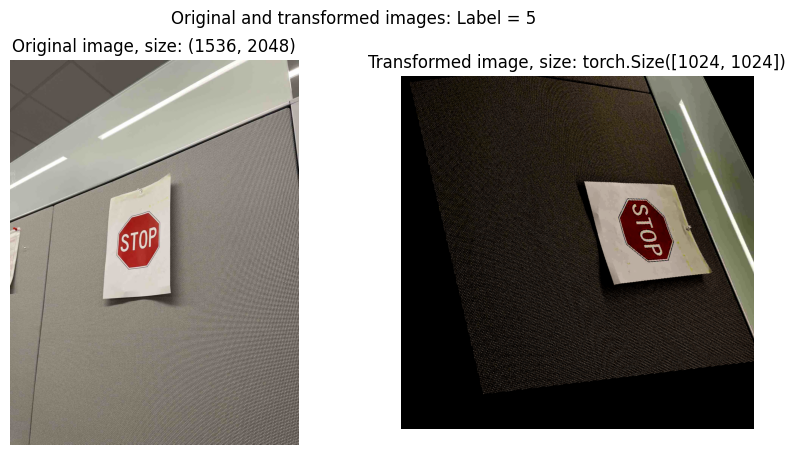

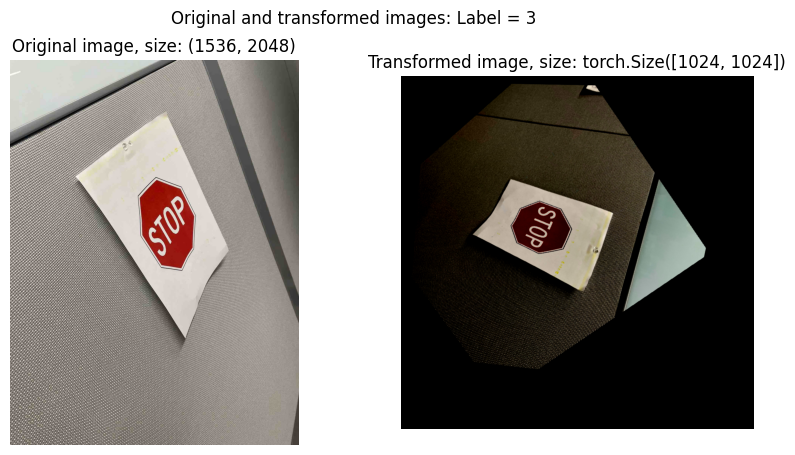

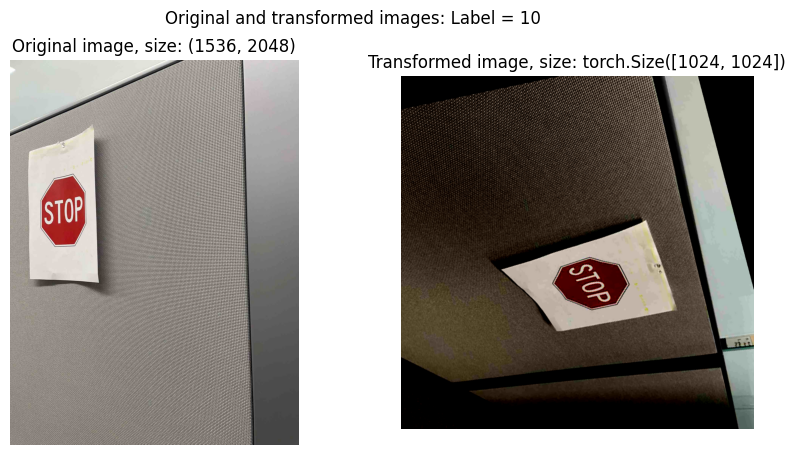

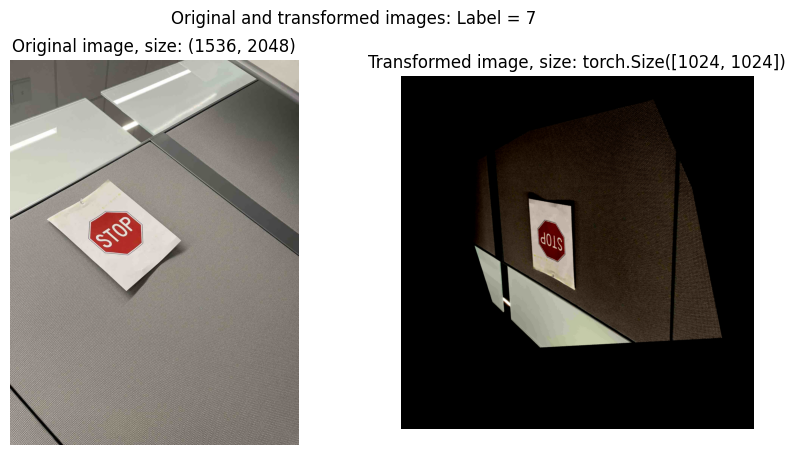

In [33]:
batch_size = 4
train_dataloader = DataLoader(my_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

train_data, labels = next(iter(train_dataloader))

#plot images from a batch in train dataloader
for i in range(batch_size):
    og_img = Image.open(my_dataset.file_list[labels[i].item() - 1])
    tr_img = train_data[i].permute(1,2,0)
    plot_og_tr_img(og_img, tr_img, index=labels[i])


In [34]:
# Time taken for 1000 calls of __getitem__
start = time()
num_tot_images = len(my_dataset)
for i in range(1000):
    my_dataset.__getitem__(i%num_tot_images)

print("Time taken for 1000 calls of __getitem__", time() - start)

Time taken for 1000 calls of __getitem__ 635.8037867546082


In [6]:
# Time taken for 1000 image accumulations in torch Dataloader
batch_size = 8
train_dataloader = DataLoader(
    my_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)  # change num_workers to 0/1/4 to see the difference

start = time()

count = 0
while True:
    for img, labels in train_dataloader:
        count += labels.shape[0]
    if count >= 1000:
        break

print("Time taken for 1000 calls of torch Dataloader", time() - start)


Time taken for 1000 calls of torch Dataloader 547.9829866886139
